In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [94]:
dat = np.load("CalibrationHitPattern.npz")

In [95]:
## fit the device parameters

def gain_fit(x,dg):
    return dg*x
    
def ca_fit(x,a):
    return a*x**2 


## gain vs ov
gdat = np.loadtxt('gain_vs_ov.txt', delimiter=',', skiprows=1)
gain_fit_vs_ov, bcov = curve_fit(gain_fit, gdat[:,0], gdat[:,1])
xx = np.linspace(0,8)
plt.figure()
#plt.plot(gdat[:,0], gdat[:,1], 'bo')
plt.plot(xx, gain_fit(xx, gain_fit_vs_ov), 'b')
plt.xlim(0,8)
plt.ylim(0, 6e6)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('gain_fit.png', transparent=True)
print("Fit to HPK gain [e/OV]: ", gain_fit_vs_ov)


## now the CA
cadat = np.loadtxt('ca_vs_ov.txt', delimiter=',', skiprows=1)
ca_fit_vs_ov, bcov = curve_fit(ca_fit, cadat[:,0], cadat[:,1])
xx = np.linspace(0,9)
plt.figure()
#plt.plot(cadat[:,0], cadat[:,1], 'bo')
plt.plot(xx, ca_fit(xx, *ca_fit_vs_ov), 'b')
plt.xlim(0,9)
plt.ylim(0, 3.5)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('ca_fit.png', transparent=True)
print("Fit to CA: ", ca_fit_vs_ov)

## now PDE
pdedat = np.loadtxt('pde_vs_ov.txt', delimiter=',', skiprows=1)
pde_fit = interp1d(pdedat[:,0], pdedat[:,1], fill_value="extrapolate", kind='quadratic')
xx = np.linspace(0,9)
plt.figure()
#plt.plot(pdedat[:,0], pdedat[:,1], 'bo')
plt.plot(xx, pde_fit(xx), 'b')
plt.xlim(0,9)
plt.ylim(5, 40)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('pde_fit.png', transparent=True)

plt.close('all')

Fit to HPK gain [e/OV]:  [735379.99731711]
Fit to CA:  [0.00883131]


In [96]:
x = dat['X']
y = dat['Y']
hp = dat['HitPattern']
print(np.shape(x))
print(np.shape(y))
print(np.shape(hp))

(41, 193)
(41, 193)
(192, 40)


In [100]:
### parameters for OV analysis:

scale_fac = 1 ## kludge for now to allow arbitrary scaling of counts -- eventually this should be set to 1
applied_OV = 4 ## Volts (intended) overvoltage
num_secs = 10 ## 10 s long file (10k events)
e_to_coul = 1.6e-19 ## coulombs per electron
r_bias = 100e6 ## Ohm

In [101]:
photon_per_s_map = hp.T/(num_secs) * scale_fac
pe_per_s_map = photon_per_s_map * (1 + ca_fit(4, *ca_fit_vs_ov))
ov_map = applied_OV/(1 + r_bias * gain_fit_vs_ov * pe_per_s_map * e_to_coul)

gain_map = gain_fit(ov_map, gain_fit_vs_ov)
pde_map = pde_fit(ov_map)
ca_map = ca_fit(ov_map, *ca_fit_vs_ov)

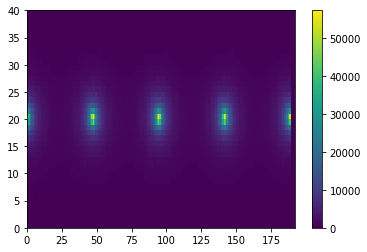

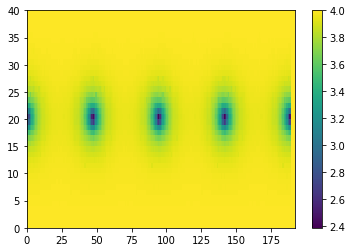

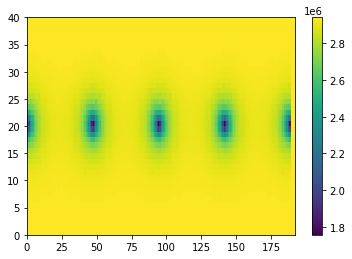

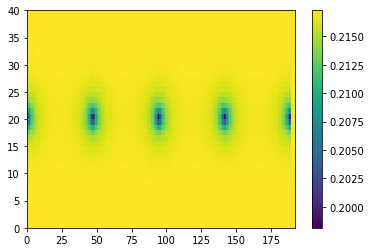

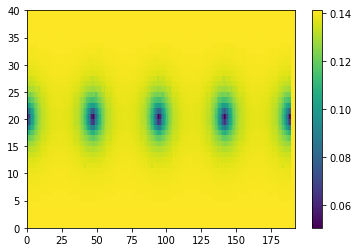

In [103]:
plt.figure()
plt.pcolormesh(pe_per_s_map)
plt.colorbar()

plt.figure()
plt.pcolormesh(ov_map) #, vmin=0, vmax=100000)
plt.colorbar()

plt.figure()
plt.pcolormesh(gain_map) #, vmin=0, vmax=100000)
plt.colorbar()

plt.figure()
plt.pcolormesh(pde_map/100) #, vmin=0, vmax=100000)
plt.colorbar()

plt.figure()
plt.pcolormesh(ca_map) #, vmin=0, vmax=100000)
plt.colorbar()


In [104]:
## now we have all the maps, we want to look at the energy reconstruction

event_dat = np.load("CenterTemplate.npy")
event_dat[np.isnan(event_dat)] = 0
center_shape = event_dat.T/np.sum(event_dat)
print(np.sum(event_dat))

189.0


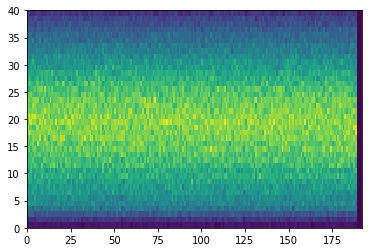

In [105]:
plt.figure()
plt.pcolormesh(center_shape)
plt.show()

In [106]:
## now make a plot of the response before/after the current draw

dbefore = np.sum(center_shape)
dafter = np.sum(center_shape * gain_map/gain_fit(4, gain_fit_vs_ov) * pde_map/(pde_fit(4)) * (1 + ca_map)/(1 + ca_fit(4, *ca_fit_vs_ov)))

dafter_gain_corr = np.sum(center_shape * pde_map/(pde_fit(4)) * (1 + ca_map)/(1 + ca_fit(4, *ca_fit_vs_ov)))


print(dbefore, dafter, dafter_gain_corr)

1.0 0.9695837720043362 0.9915256361779702


In [90]:
dat = np.load("TestHitPattern.npz")

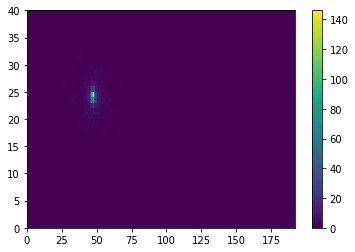

In [92]:
plt.pcolormesh(dat['HitPattern'].T)
plt.colorbar()